# this notebook tries to validate the thermal model - all C rate on
# split into 2: one for double and one for single

In [59]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import pybamm;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing;import pandas as pd;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [61]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
# BasicPath = "C:/Users/rl1120/OneDrive - Imperial College London/"  #
BasicPath= "D:/OneDrive - Imperial College London/SimDataSave/P3R13/Validation/"
Target  = 'Try_2/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [62]:
# define parameter of double and single 
Para_dict_Same = {
   ################################# Same for single and double:
   #"Particle mesh points":[80,],
   "Mesh list":[ [10,5,10,30,20], ],   # Simon uses 30
   "Para_Set":[ "Li2023_ECdrag",],
   # solvent diffusion parameters:
   "EC initial concentration in electrolyte [mol.m-3]":[3500],
   "Typical EC concentration [mol.m-3]":[3500,],
   # DFN parameter
   "Upper voltage cut-off [V]":[4.21,],
   "Lower voltage cut-off [V]":[2.49,],
   "Negative electrode diffusivity [m2.s-1]":[
        3.3e-14,],     # "graphite_LGM50_diffusivity_ORegan2022"
   "Positive electrode diffusivity [m2.s-1]":[
        4e-15,],       # "nmc_LGM50_diffusivity_ORegan2022"
   # if want a function, add 'Func', 
   #    if want a constant, delete Func
   # note!!!: Constant will overwrite Func
   "Electrolyte conductivity [S.m-1]":[
        "electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Con",
        ],
    "Electrolyte diffusivity [m2.s-1]":[
        "electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Con",],
    "EC transference number":[
        "EC_transference_number",],
    "Cation transference number":[
        "electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Con",],
   # general SEI
   'SEI resistivity [Ohm.m]':[2E5,],
   "Initial inner SEI thickness [m]":[2.5e-9,],
   "Initial outer SEI thickness [m]":[2.5e-9,],
   # Heat parameter:
   "Total heat transfer coefficient [W.m-2.K-1]":[300,400,450],
   "Reference temperature [K]":[298.15,],
   "Ambient temperature [K]":[298.15,],
   "Initial temperature [K]":[298.15,],
}

Para_dict_DD_ONLY = {
     "Model option":[{
          "solvent diffusion": "double spatial consume w refill",
          "electrolyte conductivity": "sol full"  ,
          "thermal": "lumped"   },],
     ################################# Need to be different between single and double:
     "EC Lithium ion cross diffusivity [m2.s-1]":[
        "Cross_diffusivity_1p5E_10",], # "Cross_diffusivity_1p5E_12",
     "EC diffusivity in electrolyte [m2.s-1]":[
        "EC_diffusivity_5E_10"],
     "EC transference number":[
        "EC_transference_number",],
     "Measured dLJP_dcEC": ["dLJP_Two_Species_dco_Jung2023",],
     "Measured dLJP_dce": ["dLJP_Two_Species_dce_Jung2023",],
}
Para_dict_SD_ONLY = {
     "Model option":[{
          "solvent diffusion": "single no consume wo refill",
          "electrolyte conductivity": "full"  ,
          "thermal": "lumped" },],
     ################################# fake, must have only one option
     "EC Lithium ion cross diffusivity [m2.s-1]":[
        "Cross_diffusivity_1p5E_10",],
     "EC diffusivity in electrolyte [m2.s-1]":[
        "EC_diffusivity_5E_10"],
     "EC transference number":[
        "EC_transference_number",],
     "Measured dLJP_dce":["dLJP_One_Specie_dce_Jung2023",]
}
Para_dict_DD = {**Para_dict_Same,**Para_dict_DD_ONLY}
Para_dict_SD = {**Para_dict_Same,**Para_dict_SD_ONLY}
Para_DD = [];  Para_SD=[];
recursive_scan(Para_DD,Para_dict_DD, list(Para_dict_DD.keys()), {})
recursive_scan(Para_SD,Para_dict_SD, list(Para_dict_SD.keys()), {})
print(len(Para_DD),len(Para_SD))

3 3


In [63]:
# Summarize Exp - plot temperature rise and capacity vs C rate
Niall_Crate = [0.2, 0.3, 0.4, 0.5, 1, 2, 3]; 
Niall_Cap = [ 4.815, 4.75, 4.82, 4.82, 4.64, 3.298, 1.983]; 
Ruihe_Crate = [0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5, 4.0]
RL_Cap_Cell_1 = [4.715963693555362, 4.612124591646047, 4.525131462728684, 4.357837218694934, 3.9985270604389145, 3.4233452957546677, 2.5758641034678815, 1.988704897546658, 1.6652388357649741, 1.4100456949750437]
RL_Cap_Cell_2 = [4.716030959172494, 4.617948432702642, 4.5276396589819425, 4.341444372881664, 3.9091685871110027, 3.286849922924804, 2.4498175045751953, 1.901398288847656, 1.57583310209744, 1.345814775172526]
# Biologic temperature:
RL_T_Rise_Cell_1 = [1.8637965639005145, 2.6184089732547733, 2.2785406232761183, 2.7299726754489058, 3.4454458756196686, 3.2409775493440662, 4.36836993533397, 4.043625726318339, 4.889784013534822, 5.519928668485186]
RL_T_Rise_Cell_2 = [1.6080960965963662, 1.5360009591223402, 2.038724388471504, 2.0249414408349473, 2.984494420154249, 3.5199766991718633, 4.342076997341994, 4.719743013070929, 3.79700883048751, 3.071455647673517]
# from 1C to 3C only
Pico_T_Rise_Cell_1 =[
    26.643-25.982, 26.778-25.974,
    27.133-25.889,27.481-25.917,27.6-25.9,
    28.023-26,28.229-25.952]
Pico_T_Rise_Cell_2 =[
    26.411-25.706,26.671-25.681,27.025-25.611,
    27.481-25.644,27.7-25.6,28.361-25.739, 28.832-25.633]

In [64]:
# Write scan parameters
book_name_xlsx = 'Test.xlsx';sheet_name_xlsx = 'Results';
Path_Exp_Crate = "D:/OneDrive - Imperial College London/SimDataSave/InputData/Ruihe_newLGM50_Crate/"
Path_pack = [BasicPath,Target,Path_Exp_Crate,book_name_xlsx,sheet_name_xlsx,];
Index_DD = np.arange(1,len(Para_DD)+1).tolist()  
Index_SD = np.arange(1,len(Para_SD)+1).tolist()  
str_model_DD = "Double";  str_model_SD = "DFN"
# Write the head for excel file:
head_list = list(Para_DD[0].keys())
head_list.insert(0,"Index");
Values_1 = [head_list,];
for Scan_i,Para_dict_i in zip(Index_DD,Para_DD):
    value_list_temp = list(Para_dict_i.values())
    values = []
    for value_list_temp_i in value_list_temp:
        values.append(str(value_list_temp_i))
    values.insert(0,str(Scan_i))
    Values_1.append(values)
write_excel_xlsx(
    BasicPath + Target+ str_model_DD + "_" +  book_name_xlsx, 
    sheet_name_xlsx, Values_1)  
# Write the head for excel file:
head_list = list(Para_SD[0].keys())
head_list.insert(0,"Index");
Values_1 = [head_list,];
for Scan_i,Para_dict_i in zip(Index_SD,Para_SD):
    value_list_temp = list(Para_dict_i.values())
    values = []
    for value_list_temp_i in value_list_temp:
        values.append(str(value_list_temp_i))
    values.insert(0,str(Scan_i))
    Values_1.append(values)
write_excel_xlsx(
    BasicPath + Target+ str_model_SD + "_" + book_name_xlsx, 
    sheet_name_xlsx, Values_1)        

Successfully create a excel file
Successfully create a excel file


In [65]:
# scan: DD and SD respectively 
DD_Dis_All = []; SD_Dis_All = [];   Rate_Dis_All =Ruihe_Crate[0:-2:2];  
if __name__ == "__main__":
    pool = multiprocessing.Pool(3)
    processes = [pool.apply_async(
        Scan_Crate_Dict, 
        args=(
            index_i, Para_dd_i, Path_pack , str_model_DD,
            Rate_Dis_All,True,True,
         )) 
         for Para_dd_i,index_i in zip(Para_DD,Index_DD)]
    result_DD = [p.get() for p in processes] 
# Scan SD
if __name__ == "__main__":
    pool = multiprocessing.Pool(3)
    processes = [pool.apply_async(
        Scan_Crate_Dict, 
        args=(
            index_i, Para_sd_i, Path_pack , str_model_SD,
            Rate_Dis_All,True,True,
         )   ) 
         for Para_sd_i,index_i in zip(Para_SD,Index_SD)]
    result_SD = [p.get() for p in processes] 



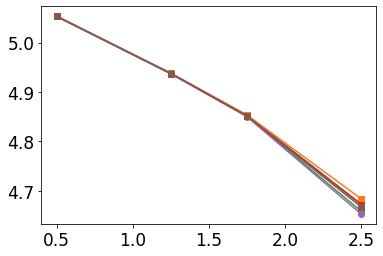

In [66]:
# plt.plot(result_DD[0]["Time_dis_All"][-1],result_DD[0]["Vol_dis_All"][-1])
for i in range(3):
    plt.plot(result_DD[i]["Rate_Dis_All"],result_DD[i]["Cap_Dis_All"],"-o")
    plt.plot(result_SD[i]["Rate_Dis_All"],result_SD[i]["Cap_Dis_All"],"-s")

Text(0.5, 0, 'C rate')

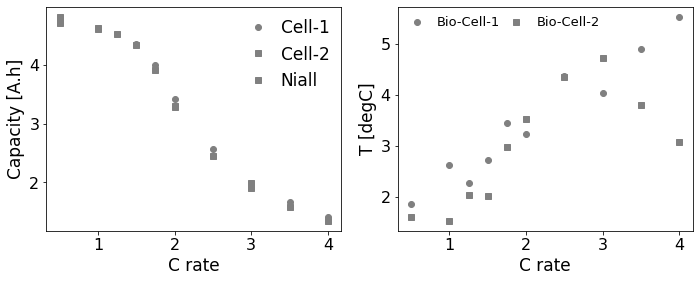

In [67]:
# ref: plot exp data:
font = {'family' : 'DejaVu Sans','size'   : 16};mpl.rc('font', **font)
fig, axs = plt.subplots(1,2, figsize=(10,4.2),tight_layout=True)
axs[0].plot(Ruihe_Crate, RL_Cap_Cell_1 ,linestyle='none',marker ="o", color="gray",label="Cell-1")
axs[0].plot(Ruihe_Crate, RL_Cap_Cell_2 ,linestyle='none',marker ="s",color="gray",label="Cell-2")
axs[0].plot(Niall_Crate[3:], Niall_Cap[3:] ,linestyle='none',marker ="s",color="gray",label="Niall")
axs[1].plot(Ruihe_Crate, RL_T_Rise_Cell_1 ,linestyle='none',marker ="o",color="gray",label="Bio-Cell-1")
axs[1].plot(Ruihe_Crate, RL_T_Rise_Cell_2 ,linestyle='none',marker ="s",color="gray",label="Bio-Cell-2")
#axs[1].plot(Ruihe_Crate[1:8], Pico_T_Rise_Cell_1 ,linestyle='--',marker ="o",color="k",label="Pico-Cell-1")
#axs[1].plot(Ruihe_Crate[1:8], Pico_T_Rise_Cell_2 ,linestyle='--',marker ="s",color="c",label="Pico-Cell-2")
axs[0].legend(prop={'family':'DejaVu Sans','size':fs},
    loc='best',ncol=1,frameon=False,markerscale=1,borderpad=0.2,handlelength=1.0,columnspacing=0.5)
axs[1].legend(prop={'family':'DejaVu Sans','size':fs-4},
    loc='best',ncol=2,frameon=False,markerscale=1,borderpad=0.2,handlelength=1.5,columnspacing=0.5)
axs[0].set_ylabel("Capacity [A.h]",fontsize=fs)
axs[1].set_ylabel("T [degC]",fontsize=fs)
axs[1].set_xlabel("C rate",fontsize=fs)
axs[0].set_xlabel("C rate",fontsize=fs)

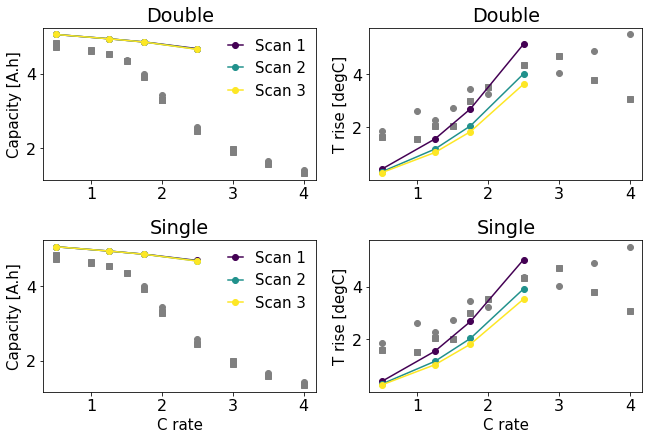

In [68]:
# compare all results - different scans
ls = "-"
# Compare experiment and modelling result: temperature rise and capacity vs C rate
fig, axs = plt.subplots(2,2, figsize=(9.3,6.4),tight_layout=True)
# experiment:
axs[0,0].plot(Ruihe_Crate, RL_Cap_Cell_1 ,linestyle='none',marker ="o", color="gray",) # label="Cell-1"
axs[0,0].plot(Ruihe_Crate, RL_Cap_Cell_2 ,linestyle='none',marker ="s",color="gray",) # label="Cell-2"
axs[0,0].plot(Niall_Crate[3:], Niall_Cap[3:] ,linestyle='none',marker ="s",color="gray",) # label="Niall"
axs[0,1].plot(Ruihe_Crate, RL_T_Rise_Cell_1 ,linestyle='none',marker ="o",color="gray",)  # label="Bio-Cell-1"
axs[0,1].plot(Ruihe_Crate, RL_T_Rise_Cell_2 ,linestyle='none',marker ="s",color="gray",) # label="Bio-Cell-2"

axs[1,0].plot(Ruihe_Crate, RL_Cap_Cell_1 ,linestyle='none',marker ="o", color="gray",) # label="Cell-1"
axs[1,0].plot(Ruihe_Crate, RL_Cap_Cell_2 ,linestyle='none',marker ="s",color="gray",) # label="Cell-2"
axs[1,0].plot(Niall_Crate[3:], Niall_Cap[3:] ,linestyle='none',marker ="s",color="gray",) # label="Niall"
axs[1,1].plot(Ruihe_Crate, RL_T_Rise_Cell_1 ,linestyle='none',marker ="o",color="gray",)  # label="Bio-Cell-1"
axs[1,1].plot(Ruihe_Crate, RL_T_Rise_Cell_2 ,linestyle='none',marker ="s",color="gray",) # label="Bio-Cell-2"
# simulation - double
cmdd = mpl.cm.get_cmap("viridis", len(result_DD)) 
for i in range(len(result_DD)):
    axs[0,0].plot( 
        result_DD[i]["Rate_Dis_All"],result_DD[i]["Cap_Dis_All"],
        linestyle=ls,marker ="o", color=cmdd(i),label=f"Scan {i+1}" )
    axs[0,1].plot( 
        result_DD[i]["Rate_Dis_All"],result_DD[i]["Trise_All"],
        linestyle=ls,marker ="o", color=cmdd(i),label=f"Scan {i+1}" )
# simulation - single
cmsd = mpl.cm.get_cmap("viridis", len(result_SD)) 
for i in range(len(result_SD)):
    axs[1,0].plot( 
        result_SD[i]["Rate_Dis_All"],result_SD[i]["Cap_Dis_All"],
        linestyle=ls,marker ="o", color=cmsd(i),label=f"Scan {i+1}" )
    axs[1,1].plot( 
        result_SD[i]["Rate_Dis_All"],result_SD[i]["Trise_All"]  ,
        linestyle=ls,marker ="o", color=cmsd(i),label=f"Scan {i+1}" )

axs[0,0].legend(prop={'family':'DejaVu Sans','size':fs-2},
    loc='best',ncol=1,frameon=False,markerscale=1,borderpad=0.2,handlelength=1.0,columnspacing=0.5)
axs[1,0].legend(prop={'family':'DejaVu Sans','size':fs-2},
    loc='best',ncol=1,frameon=False,markerscale=1,borderpad=0.2,handlelength=1.0,columnspacing=0.5)

axs[0,0].set_ylabel("Capacity [A.h]",fontsize=fs-2)
axs[0,1].set_ylabel("T rise [degC]",fontsize=fs-2)
axs[1,0].set_ylabel("Capacity [A.h]",fontsize=fs-2)
axs[1,1].set_ylabel("T rise [degC]",fontsize=fs-2)
axs[1,0].set_xlabel("C rate",fontsize=fs-2)
axs[1,1].set_xlabel("C rate",fontsize=fs-2)
axs[0,0].set_title("Double",loc='center') 
axs[0,1].set_title("Double",loc='center') 
axs[1,0].set_title("Single",loc='center') 
axs[1,1].set_title("Single",loc='center') 
plt.savefig( BasicPath + Target+ f"0_Summary_Cap_Trise.png", dpi=600)   

In [45]:
def Read_ExpCrate(Path_Exp_Crate, ):
    #BasicPath = "D:/OneDrive - Imperial College London/SimDataSave/InputData/" 
    #Target = "Ruihe_newLGM50_Crate/"
    Cell_1_2p5to3C = pd.read_csv(
        Path_Exp_Crate + "dicharge_2.5C_3C_ch_a_1_CA1.txt", #engine='python',
        encoding = "shift-jis",  skiprows = 1,
        sep ='\t', header=None)
    Cell_1_2p5to3C.head()
    newNames = [
        "time/s", "Ns","Ecell/V", "I/mA", 
        "(Q-Qo)/mA.h", "Temperature/ｰC", 
        "Q charge/mA.h","Q discharge/mA.h","R/Ohm"]
    oldNames = np.arange(9).tolist()
    Cell_1_2p5to3C=Cell_1_2p5to3C.rename(columns={i:j for i,j in zip(oldNames,newNames)})
    Cell_1_2p5to3C.head()
    # Get Cell-1 2.5C and 3C:
    font = {'family' : 'DejaVu Sans','size'   : 14};   mpl.rc('font', **font)
    Cell_1_2p5C = Cell_1_2p5to3C[(Cell_1_2p5to3C['Ns']==5)]
    df_dc4 = Cell_1_2p5to3C[(Cell_1_2p5to3C['Ns']==12)]
    Cell_1_3C = Cell_1_2p5to3C[(Cell_1_2p5to3C['Ns']==12)]
    # Read Cell-2 2.5C to 3C:
    Cell_2_2p5to3C = pd.read_csv(
        Path_Exp_Crate + "dicharge_2.5C_3C_ch_a_2_CA2.txt", #engine='python',
        encoding = "shift-jis",  skiprows = 1,
        sep ='\t', header=None)
    Cell_2_2p5to3C.head()
    newNames = [
        "time/s", "Ns","Ecell/V", "I/mA", 
        "(Q-Qo)/mA.h", "Temperature/ｰC", 
        "Q charge/mA.h","Q discharge/mA.h","R/Ohm"]
    oldNames = np.arange(9).tolist()
    Cell_2_2p5to3C=Cell_2_2p5to3C.rename(columns={i:j for i,j in zip(oldNames,newNames)})
    Cell_2_2p5to3C.head()
    Cell_2_2p5C = Cell_2_2p5to3C[(Cell_2_2p5to3C['Ns']==5)]
    df_dc4 = Cell_2_2p5to3C[(Cell_2_2p5to3C['Ns']==12)]
    Cell_2_3C = Cell_2_2p5to3C[(Cell_2_2p5to3C['Ns']==12)]
    # Read Cell-1 3.5C to 4C:
    Cell_1_3p5to4C = pd.read_csv(
        Path_Exp_Crate + "Discharge_test_3p5_to_4C_A1_CA1.txt", #engine='python',
        encoding = "shift-jis",  skiprows = 1,
        sep ='\t', header=None)
    Cell_1_3p5to4C.head()
    newNames = [
        "time/s", "Ns","Ecell/V", "I/mA", 
        "(Q-Qo)/mA.h", "Temperature/ｰC", 
        "Q charge/mA.h","Q discharge/mA.h","R/Ohm"]
    oldNames = np.arange(9).tolist()
    Cell_1_3p5to4C=Cell_1_3p5to4C.rename(columns={i:j for i,j in zip(oldNames,newNames)})
    Cell_1_3p5to4C.head()
    Cell_1_3p5C = Cell_1_3p5to4C[(Cell_1_3p5to4C['Ns']==5)]
    df_dc4 = Cell_1_3p5to4C[(Cell_1_3p5to4C['Ns']==12)]
    Cell_1_4C = Cell_1_3p5to4C[(Cell_1_3p5to4C['Ns']==12)]
    # Read Cell-2 3.5C to 4C:
    Cell_2_3p5to4C = pd.read_csv(
        Path_Exp_Crate + "Discharge_test_3p5_to_4C_A2_CA3.txt", #engine='python',
        encoding = "shift-jis",  skiprows = 1,
        sep ='\t', header=None)
    Cell_2_3p5to4C.head()
    newNames = [
        "time/s", "Ns","Ecell/V", "I/mA", 
        "(Q-Qo)/mA.h", "Temperature/ｰC", 
        "Q charge/mA.h","Q discharge/mA.h","R/Ohm"]
    oldNames = np.arange(9).tolist()
    Cell_2_3p5to4C=Cell_2_3p5to4C.rename(columns={i:j for i,j in zip(oldNames,newNames)})
    Cell_2_3p5to4C.head()
    Cell_2_3p5C = Cell_2_3p5to4C[(Cell_2_3p5to4C['Ns']==5)]
    df_dc4 = Cell_2_3p5to4C[(Cell_2_3p5to4C['Ns']==12)]
    Cell_2_4C = Cell_2_3p5to4C[(Cell_2_3p5to4C['Ns']==12)]
    # Read Cell-2 up to 2C:
    Cell_2_UpTo2C = pd.read_csv(
        Path_Exp_Crate + "dicharge_to_2C_ch_a_2_CA2.txt", #engine='python',
        encoding = "shift-jis",  skiprows = 1,
        sep ='\t', header=None)
    Cell_2_UpTo2C.head()
    newNames = [
        "time/s", "Ns","Ecell/V", "I/mA", 
        "(Q-Qo)/mA.h", "Temperature/ｰC", 
        "Q charge/mA.h","Q discharge/mA.h","R/Ohm"]
    oldNames = np.arange(9).tolist()
    Cell_2_UpTo2C=Cell_2_UpTo2C.rename(columns={i:j for i,j in zip(oldNames,newNames)})
    Cell_2_UpTo2C.head()

    Cell_2_0p5C = Cell_2_UpTo2C[(Cell_2_UpTo2C['Ns']==5)]
    Cell_2_1C = Cell_2_UpTo2C[(Cell_2_UpTo2C['Ns']==12)]
    Cell_2_1p25C = Cell_2_UpTo2C[(Cell_2_UpTo2C['Ns']==19)]
    Cell_2_1p5C = Cell_2_UpTo2C[(Cell_2_UpTo2C['Ns']==26)]
    Cell_2_1p75C = Cell_2_UpTo2C[(Cell_2_UpTo2C['Ns']==33)]
    Cell_2_2C = Cell_2_UpTo2C[(Cell_2_UpTo2C['Ns']==40)]
    # Read Cell-1 up to 2C:

    Cell_1_UpTo2C = pd.read_csv(
        Path_Exp_Crate + "dicharge_to_2C_ch_a_1_CA1.txt", #engine='python',
        encoding = "shift-jis",  skiprows = 1,
        sep ='\t', header=None)
    Cell_1_UpTo2C.head()
    newNames = [
        "time/s", "Ns","Ecell/V", "I/mA", 
        "(Q-Qo)/mA.h", "Temperature/ｰC", 
        "Q charge/mA.h","Q discharge/mA.h","R/Ohm"]
    oldNames = np.arange(9).tolist()
    Cell_1_UpTo2C=Cell_1_UpTo2C.rename(columns={i:j for i,j in zip(oldNames,newNames)})
    Cell_1_UpTo2C.head()

    Cell_1_0p5C = Cell_1_UpTo2C[(Cell_1_UpTo2C['Ns']==5)]
    Cell_1_1C = Cell_1_UpTo2C[(Cell_1_UpTo2C['Ns']==12)]
    Cell_1_1p25C = Cell_1_UpTo2C[(Cell_1_UpTo2C['Ns']==19)]
    Cell_1_1p5C = Cell_1_UpTo2C[(Cell_1_UpTo2C['Ns']==26)]
    Cell_1_1p75C = Cell_1_UpTo2C[(Cell_1_UpTo2C['Ns']==33)]
    Cell_1_2C = Cell_1_UpTo2C[(Cell_1_UpTo2C['Ns']==40)]
    # collect all together
    Cell_2_All = [
        Cell_2_0p5C,Cell_2_1C,Cell_2_1p25C,Cell_2_1p5C,Cell_2_1p75C,
        Cell_2_2C,Cell_2_2p5C,Cell_2_3C,Cell_2_3p5C,Cell_2_4C];
    Cell_1_All = [
        Cell_1_0p5C,Cell_1_1C,Cell_1_1p25C,Cell_1_1p5C,Cell_1_1p75C,
        Cell_1_2C,Cell_1_2p5C,Cell_1_3C,Cell_1_3p5C,Cell_1_4C];
    str_Crate = ["0.5","1","1.25","1.5","1.75","2","2.5","3","3.5","4",]
    Num_Crate = [];
    for str in str_Crate:
        Num_Crate.append(float(str)) # print(Num_Crate)
    return Num_Crate, Cell_1_All,Cell_2_All

In [46]:
Num_Crate, Cell_1_All,Cell_2_All = Read_ExpCrate(Path_Exp_Crate, )


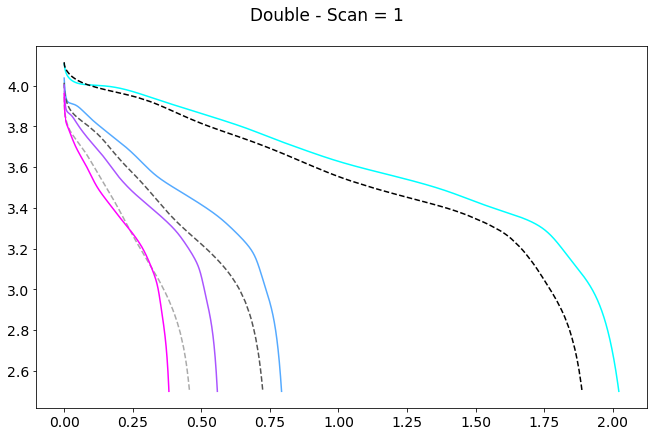

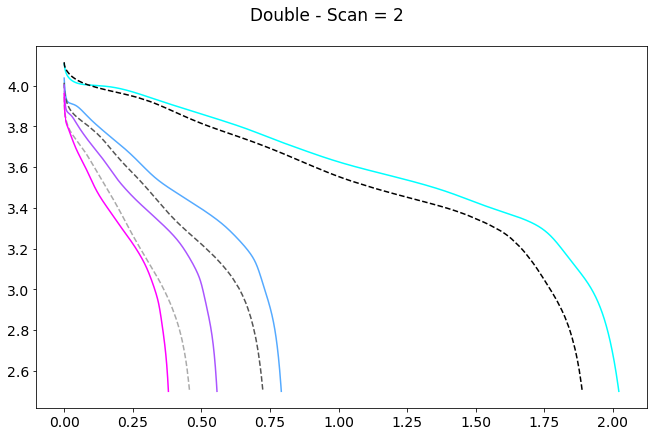

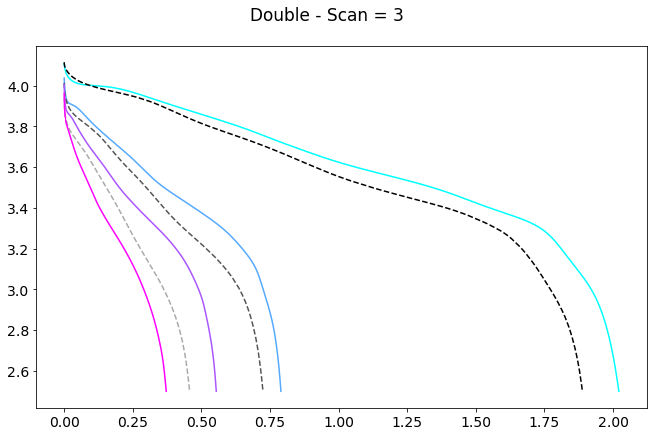

In [57]:
str_model = str_model_DD
for i in range(len(result_DD)):
    cmdd = mpl.cm.get_cmap("cool", len(Rate_Dis_All)) 
    cmgray = mpl.cm.get_cmap("gray", len(Rate_Dis_All)) 
    fig, axs = plt.subplots( figsize=(9.3,6.2),tight_layout=True)
    for j in range(len(Rate_Dis_All)):
        # plot simulation:
        axs.plot(result_DD[i]['Time_dis_All'][j],result_DD[i]['Vol_dis_All'][j], color=cmdd(j),)
        # plot experiment:
        index = Num_Crate.index(Rate_Dis_All[j])
        #print(Num_Crate[index],Rate_Dis_All[j])
        axs.plot(
            (Cell_1_All[index]["time/s"]-Cell_1_All[index]["time/s"].iloc[0])/3600,
            Cell_1_All[index]["Ecell/V"],linestyle='--',
            color=cmgray(j),)
    fig.suptitle(f'{str_model} - Scan = {i+1}', fontsize=fs)
    plt.savefig( BasicPath + Target+
        f"{str_model} - Scan={i+1} Vol compare.png", dpi=600)    


Text(0.5, 0, 'Time [s]')

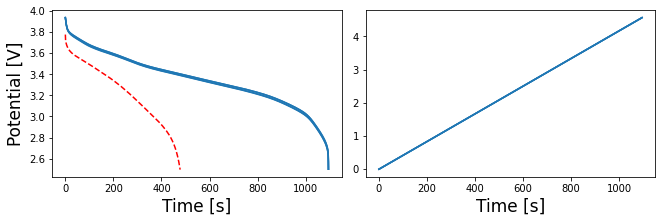

In [10]:
# to do: compare voltage: 

Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e'];
font = {'family' : 'DejaVu Sans','size'   : 16}
mpl.rc('font', **font)
Crate_index = -1;   
LS = ['-','--','-','--'];
fig, axs = plt.subplots(1,2, figsize=(9.3,3.2),tight_layout=True)
for i in range(2):
    for j in range(2):
        sol = TDF_Dis_All[i][j]['MyDict_All'][Crate_index]['Solution']
        step =  sol.cycles[0].steps[1]
        axs[0].plot(
            step['Time [s]'].entries-step['Time [s]'].entries[0], 
            step["Terminal voltage [V]"].entries,
            color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 
        axs[1].plot(
            step['Time [s]'].entries-step['Time [s]'].entries[0], 
            step["Discharge capacity [A.h]"].entries-step["Discharge capacity [A.h]"].entries[0],
            color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 
# str_Crate = ["0.5","1","1.25","1.5","1.75","2","2.5","3","3.5","4",]
i=7
axs[0].plot(
    (Cell_1_All[i]["time/s"]-Cell_1_All[i]["time/s"].iloc[0])/1,
    Cell_1_All[i]["Ecell/V"],linestyle='--',
    color="r",label=f"{str_Crate[i]} C")

axs[0].set_ylabel("Potential [V]",fontsize=fs)
axs[1].set_xlabel("Time [s]",fontsize=fs)
axs[0].set_xlabel("Time [s]",fontsize=fs)

#plt.savefig(BasicPath + Target+"Fig. 2 - 3C discharge vol decompos.png", dpi=800)

In [62]:
print(Rate_Dis_All,Ruihe_Crate)


[0.5, 1.25, 1.75, 2.5] [0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5, 4.0]


In [52]:
index = Ruihe_Crate.index(Rate_Dis_All[1])
print(Ruihe_Crate[index],Rate_Dis_All[1])

1.25 1.25
